In [1]:
import os, fnmatch, cv2
import numpy as np
import matplotlib.pyplot as plt
from models import Noise2Same
os.environ['CUDA_VISIBLE_DEVICES']='3'

### Training

#### Load noisy images (training data is already normalized).

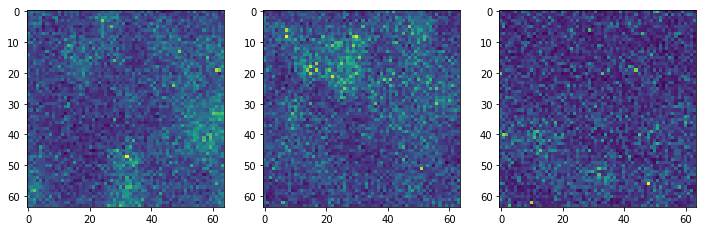

In [2]:
data = np.load('Denoising_data/Denoising_Planaria/train_data/data_label.npz')
X = data['X'].astype('float32').transpose([0,2,3,4,1])
X, X_val = X[:int(len(X)*0.9)], X[int(len(X)*0.9):]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.max(X[4,...,0], axis=0));
plt.subplot(1,3,2)
plt.imshow(np.max(X[7,...,0], axis=0));
plt.subplot(1,3,3)
plt.imshow(np.max(X[14,...,0], axis=0));

#### Build denoising model and start training.

In [3]:
model = Noise2Same('trained_models/', 'denoising_Planaria', dim=3, in_channels=1)

In [4]:
model.train(X, patch_size=[16,64,64], validation=X_val, steps=50000, batch_size=4)

### Testing/Evaluation

#### Load testing image and do evaluation. 

In [5]:
# Utils used in original CARE code
from utils.evaluation_utils import get_scores, normalize
from tifffile import imread

According to Weigert, M. et al. [1], the input images and ground truth images requires percentile normalization due to some voxels with extreme large/small values.

[1] Weigert, M., Schmidt, U., Boothe, T. et al. Content-aware image restoration: pushing the limits of fluorescence microscopy. Nat Methods 15, 1090–1097 (2018).

We use model.crop_predict() to avoid OOM issue since the input 3D volume is very large. It may take hours to finish. You can also set larger cropping size (currently 256) to make the it faster.

In [6]:
path = '../Unet/data/Denoising_Planaria/test_data/'
image_list = os.listdir(path+'GT/')
preds = {'c1':[], 'c2':[], 'c3':[], 'y':[]}
for img in image_list:
    preds['y'].append(imread(path+'GT/'+img))
    x_c1 = imread(path+'condition_1/'+img)
    x_c2 = imread(path+'condition_2/'+img)
    x_c3 = imread(path+'condition_3/'+img)
    preds['c1'].append(model.crop_predict(normalize(x_c1), 256, 32, im_mean=0, im_std=1.0))
    preds['c2'].append(model.crop_predict(normalize(x_c2), 256, 32, im_mean=0, im_std=1.0))
    preds['c3'].append(model.crop_predict(normalize(x_c3), 256, 32, im_mean=0, im_std=1.0))

In [7]:
scores = {'c1':[], 'c2':[], 'c3':[]}
for idx in range(len(preds['y'])):
    scores['c1'].append(get_scores(normalize(preds['y'][idx], 0.1, 99.9), preds['c1'][idx]))
    scores['c2'].append(get_scores(normalize(preds['y'][idx], 0.1, 99.9), preds['c2'][idx]))
    scores['c3'].append(get_scores(normalize(preds['y'][idx], 0.1, 99.9), preds['c3'][idx]))

Evaluate with three metrics. 

- From left to right, the metrics are NRMSE, PSNR, SSIM.

- From top to bottom, the results are for input images at three different noise level due to different lighting conditions.

In [8]:
(np.array(scores['c1']).mean(0),
np.array(scores['c2']).mean(0),
np.array(scores['c3']).mean(0))

(array([ 0.03296397, 29.80595079,  0.65969659]),
 array([ 0.04426956, 27.25334902,  0.51686993]),
 array([ 0.07475426, 22.5578623 ,  0.23937506]))

#### Visualization

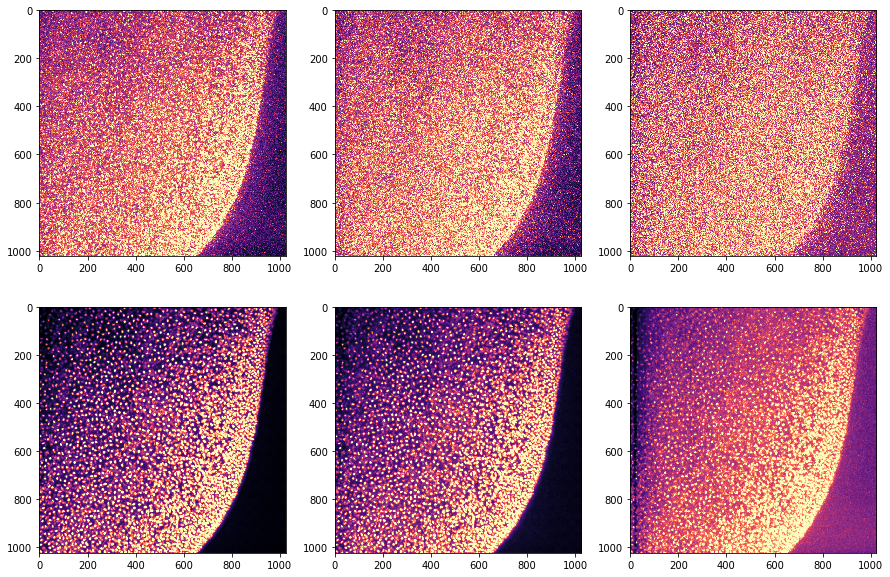

In [9]:
plt.figure(figsize=(15,10))
img = image_list[0]

plt.subplot(231)
plt.imshow(np.max(normalize(imread(path+'condition_1/'+img),clip=True), axis=0), cmap='magma')
plt.subplot(232)
plt.imshow(np.max(normalize(imread(path+'condition_2/'+img),clip=True), axis=0), cmap='magma')
plt.subplot(233)
plt.imshow(np.max(normalize(imread(path+'condition_3/'+img),clip=True), axis=0), cmap='magma')
plt.subplot(234)
plt.imshow(np.max(normalize(preds['c1'][0],clip=True), axis=0), cmap='magma')
plt.subplot(235)
plt.imshow(np.max(normalize(preds['c2'][0],clip=True), axis=0), cmap='magma')
plt.subplot(236)
plt.imshow(np.max(normalize(preds['c3'][0],clip=True), axis=0), cmap='magma')